In [1]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


#this part is unnecessary...in jupyter...point was to test blocks of code
#switches for the three different parts of this code
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']

print(im_names_n2071)

['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']


In [4]:
hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:       
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(np.nan_to_num(hdu_data[0].data)) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

In [5]:
%matplotlib inline

openpiv, 
https://nbviewer.org/github/OpenPIV/openpiv-python-examples/blob/main/notebooks/tutorial1.ipynb

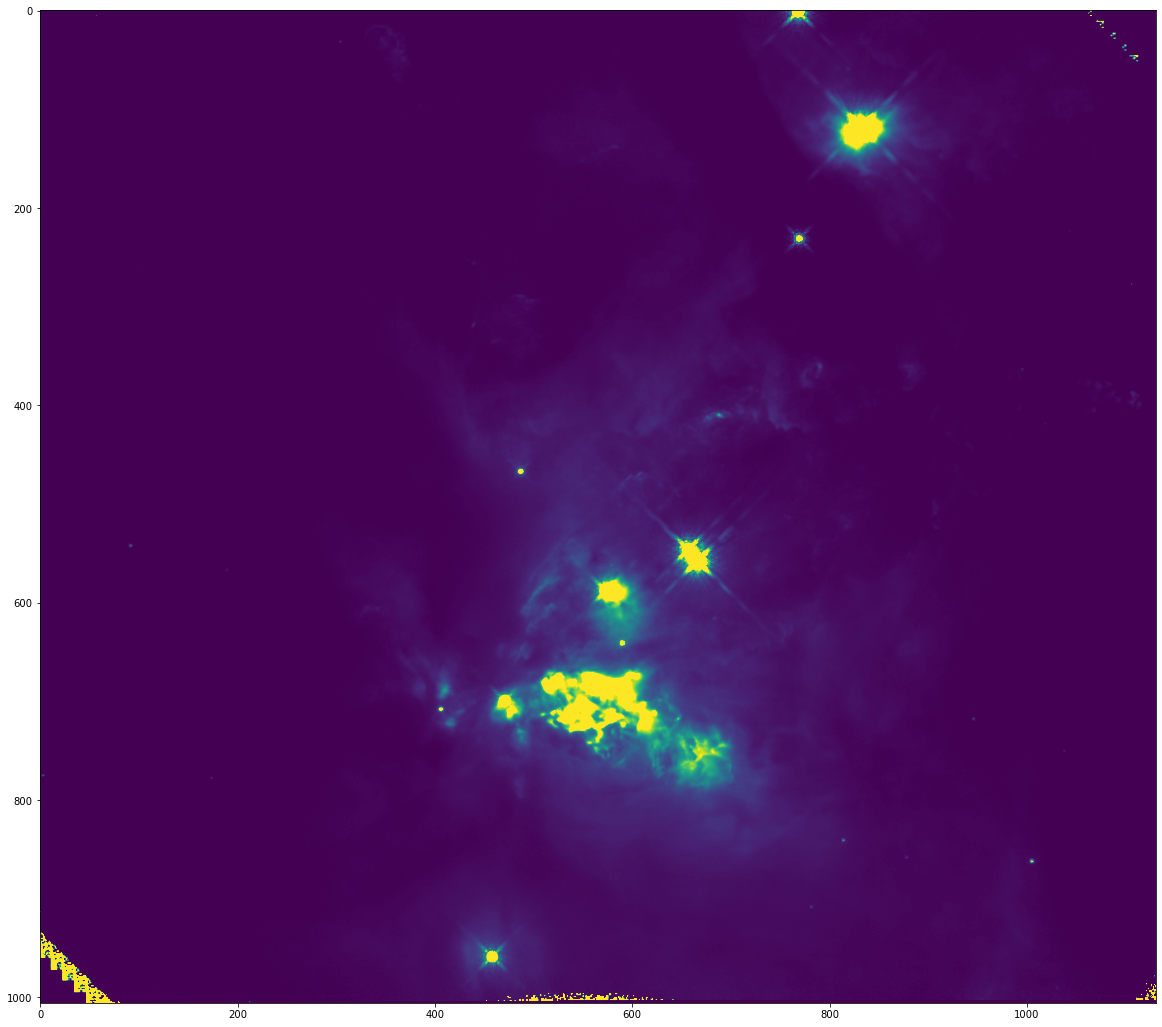

In [56]:
from openpiv import tools, pyprocess, validation, filters, scaling 

winsize = 50 # pixels, interrogation window size in frame A
searchsize = 150  # pixels, search in image B
overlap = 1 # pixels, 50% overlap
dt = 40 #3.471e+8 # 11 yr to secs, time interval between pulses

frame_a = hdu_data_list[0]
frame_b = hdu_data_list[1]

u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1 )

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 1 ) # scaling_factor tbd

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

#save in the simple ASCII table format
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(frame_a, vmin=0, vmax=1e-3)


for i in range(len(x[:, 0])):
    for j in range(len(x[0, :])):
#         print(u3[i, j], v3[i, j])
#         print(x[i, j],y[i, j],u3[i, j],v3[i, j])
        ax.arrow(x[i, j],y[i, j],u0[i, j],v0[i, j], width=1)
    # ax.quiver([x, y], u3, v3)
    
# tools.display_vector_field('exp1_001.txt', 
#                            ax=ax, scaling_factor=1, 
#                            scale=1000, # scale defines here the arrow length
#                            width=20, # width is the thickness of the arrow
#                           )



In [57]:
for i in u0:
    for j in i:
        print(j)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


skimage Active Contours seeded by my initial guesses from blinking and the difference image

can also do blob id with skimage SIFT and BRIEF feature detection but not preferred

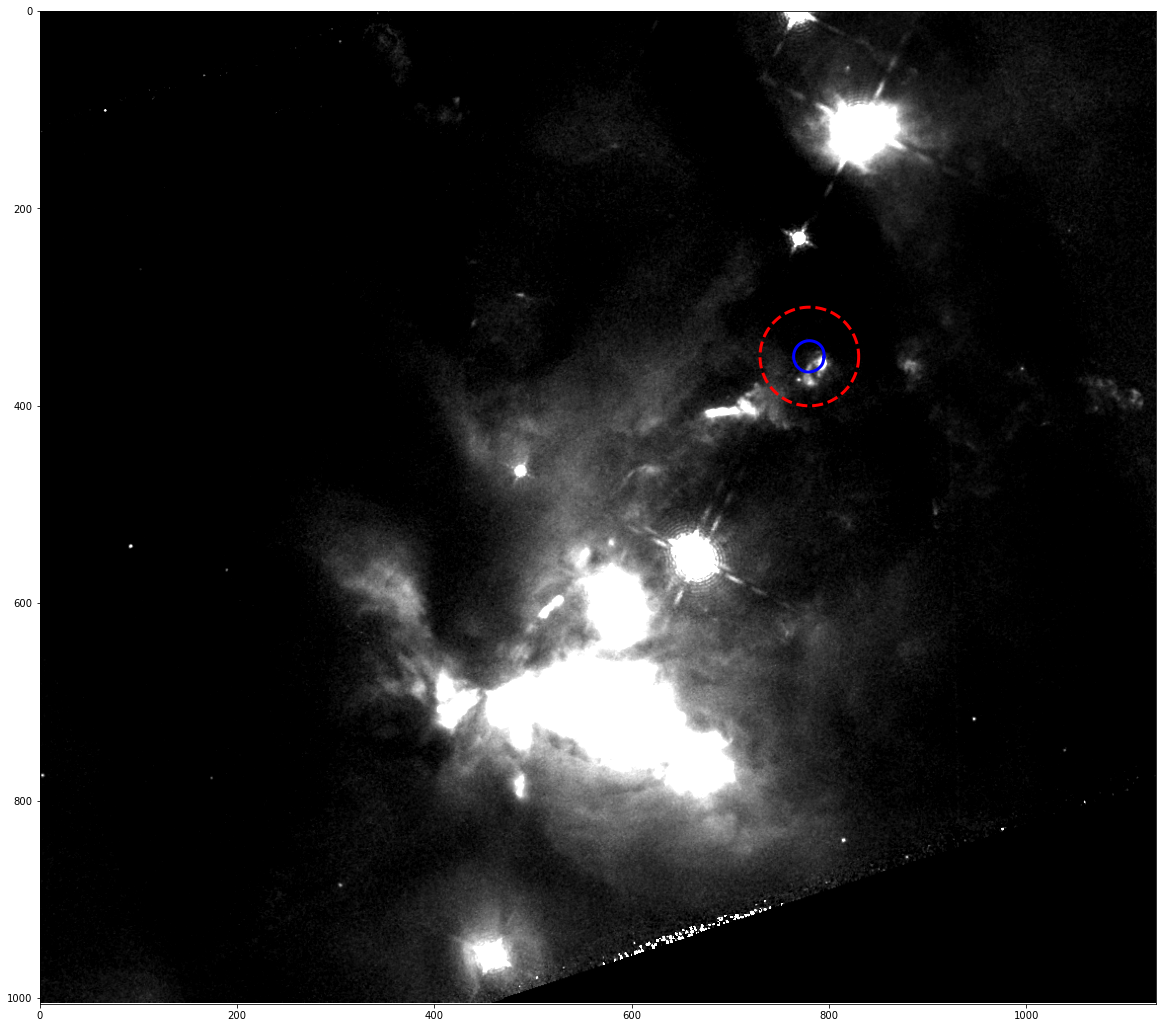

In [237]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

s = np.linspace(0, 2*np.pi, 400)
r = 350 + 50*np.sin(s)
c = 780 + 50*np.cos(s)
init = np.array([r, c]).T

img = hdu_data_list[1]

snake = active_contour(img, init, alpha=0.015, beta=0.1, gamma=0.001, w_line=1, w_edge=1)

fig, ax = plt.subplots(figsize=(20 ,20))
ax.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=0.0001)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

skeletonize(+segmentation maps at diff sigma) following https://arxiv.org/pdf/1609.02001.pdf

The general steps seem like 
1) skeletonize the two frames

2) make a sparse vector field

3) interpolate the vector field at desired locations

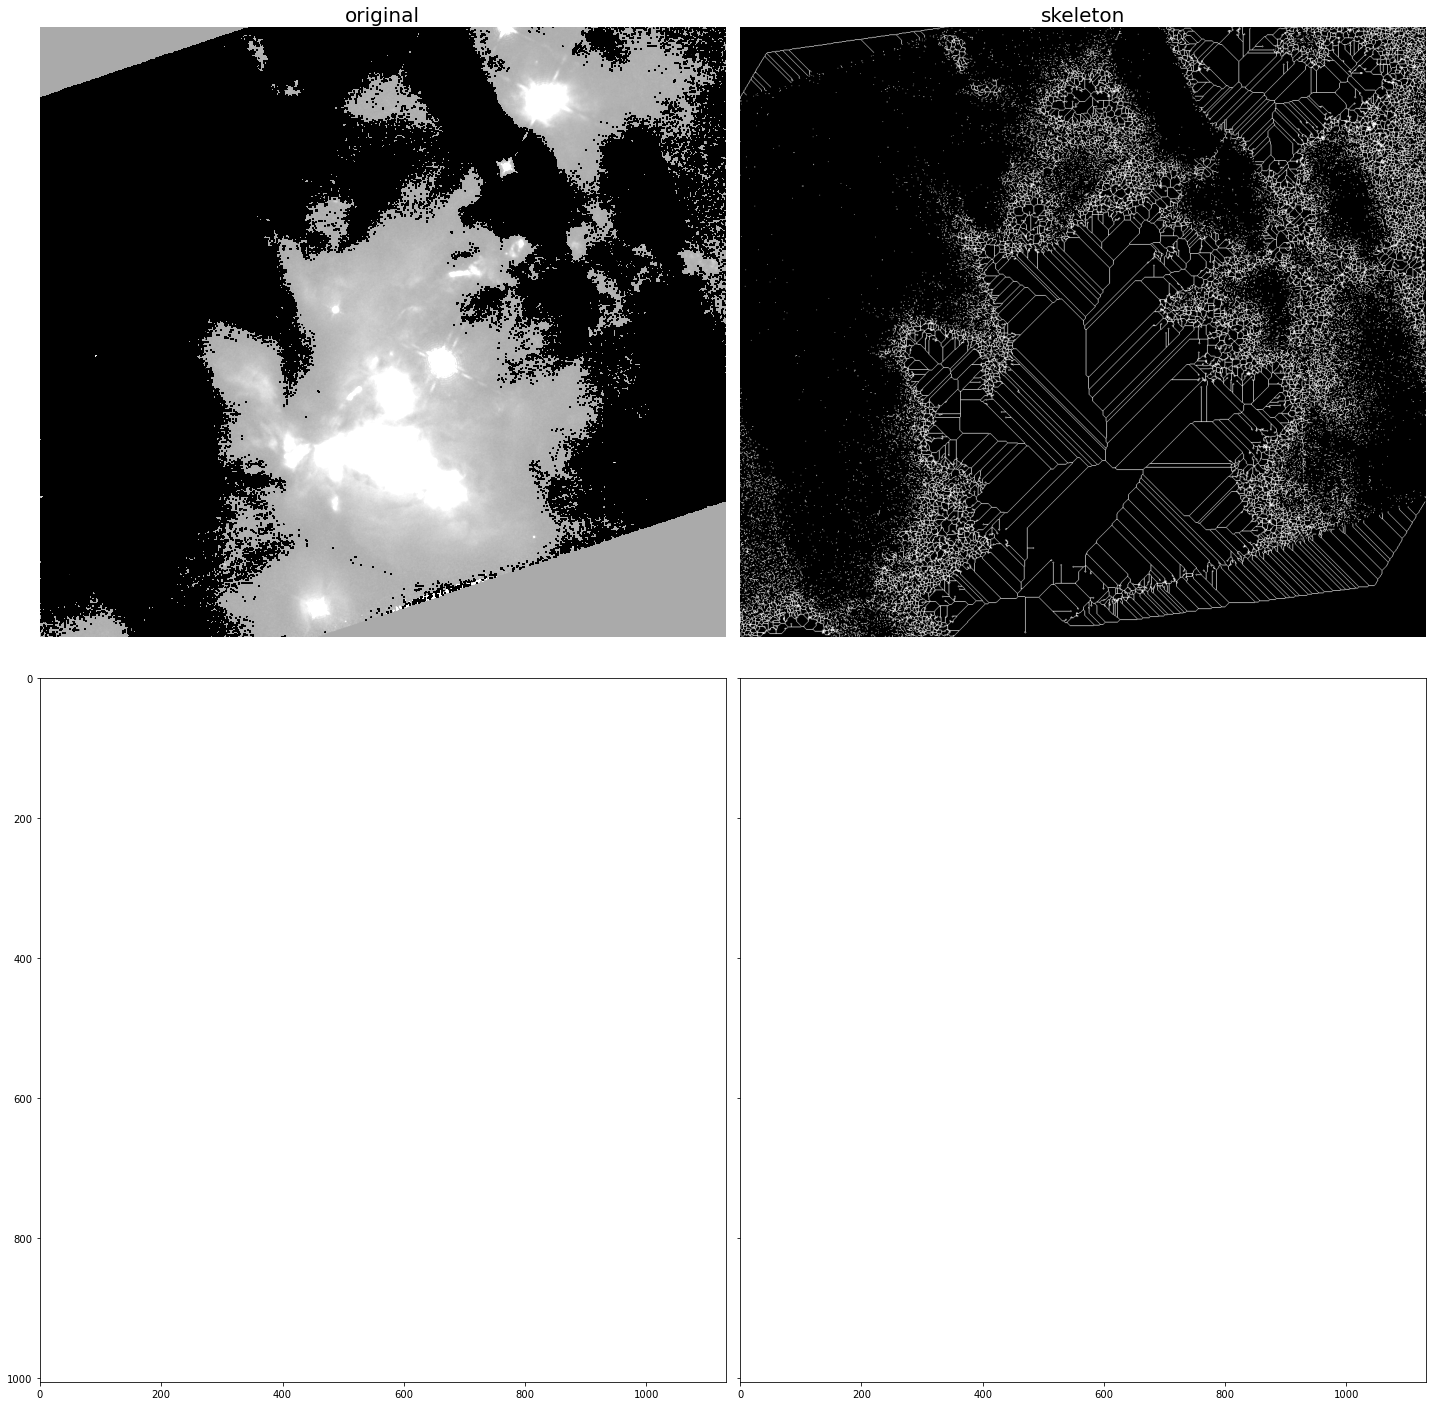

In [248]:
from skimage.morphology import skeletonize, medial_axis, thin, skeletonize_3d
from skimage.util import invert

# Invert the horse image
img = -hdu_data_list[1]
image = invert(img)
threshold = image < 0.9999999

# perform skeletonization
# skeleton = skeletonize(image-0.02, method='lee')
# skeleton = skeletonize_3d(image-0.02)
skeleton = skeletonize(image-threshold)

# Compute the medial axis (skeleton) and the distance transform
# skel, distance = medial_axis(image, return_distance=True)
# dist_on_skel = distance * skel # Distance to the background for pixels of the skeleton

#thinning
# thinned = thin(image)
# thinned_partial = thin(image, max_num_iter=300)

# display results
fig, axes = plt.subplots(2, 2, figsize=(20,20), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image-threshold, cmap=plt.cm.gray, vmin=0.9998, vmax=1.0001)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
# ax[1].contour(image, [0.999, 0.9999, 0.99999], colors='w')
# ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

# ax[2].imshow(thinned, cmap=plt.cm.gray)
# ax[2].set_title('thinned')
# ax[2].axis('off')

# ax[3].imshow(thinned_partial, cmap=plt.cm.gray)
# ax[3].set_title('partially thinned')
# ax[3].axis('off')

fig.tight_layout()
plt.show()

# trying opencv2...

In [11]:
import numpy as np
import cv2 as cv
import argparse

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

#finding some features and corners...
old_gray = hdu_data_list[0].astype('uint8')
frame_gray = hdu_data_list[0].astype('uint8')

p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_gray)
while(1):
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)
    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
cv.destroyAllWindows()

NameError: name 'frame' is not defined